In [3]:
import torch

TORCH_SEED = 69
torch.manual_seed(TORCH_SEED)

import logging
import os

os.makedirs('weights', exist_ok=True)
run_logger = logging.getLogger('run_logger')
file_handler = logging.FileHandler('weights/runs.log')
run_logger.addHandler(file_handler)


In [4]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.nn.functional import one_hot

NUM_WORKERS = 8
BATCH_SIZE = 16
INPUT_SIZE = 28
NUM_CLASSES = 10
dataset = datasets.MNIST

AUGMENTATIONS = (
        #transforms.Resize(INPUT_SIZE),
        # transforms.Resize(INPUT_SIZE + INPUT_SIZE // 4),
        # transforms.RandomResizedCrop(INPUT_SIZE, scale=(0.8, 1.0)),
        # transforms.RandomHorizontalFlip(),
)

NORMALIZATIONS = (
        transforms.ToTensor(),
        transforms.Normalize( (0.5), (0.5))
)

# Lambda can't be pickled
def one_hot_transform(label):
    return one_hot(torch.tensor(label), NUM_CLASSES).squeeze()

TARGET_TRANSFORM = transforms.Compose([
        transforms.Lambda(one_hot_transform),
])

# Load datasets
training_data = dataset(root='./data', train=True, download=True, transform=transforms.Compose(AUGMENTATIONS + NORMALIZATIONS), target_transform=TARGET_TRANSFORM)

# Load data loaders
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.84MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 200kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 1.89MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.63MB/s]


In [5]:
import model_factory

MODEL_NAME = 'context-unet'

# Load model
model = model_factory.create_model(MODEL_NAME, NUM_CLASSES, input_size=INPUT_SIZE)

In [7]:
import fine_tuning

LORA_RANK = 16
LORA_TARGET_REGEXES = ['^(?!init_conv|final_conv).*']

# Apply LoRa
model = fine_tuning.get_lora_model(model, LORA_RANK, LORA_TARGET_REGEXES)
trainable_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 2650115


In [ ]:
# Load model from save file
SAVE_FILE = 'weights/model.pth'
model = torch.load(SAVE_FILE)


In [ ]:
# Merge and unload LoRa
model.merge_and_unload()

In [ ]:
from torch import optim, nn

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0
BETA1 = 1e-4
BETA2 = 0.02
TIMESTEPS = 500

# Load optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = nn.MSELoss()

b_t = torch.linspace(BETA1, BETA2, TIMESTEPS + 1).to('cuda')
a_t = 1 - b_t
ab_t = torch.cumprod(a_t, dim=0)

In [10]:
from torch.optim.lr_scheduler import LinearLR
from tqdm import tqdm

SAVE_FILE = 'weights/mnist-unetL16.pth'
EPOCHS = 50
EVAL_EVERY = 5
LABELS_MASK_P = 0.9
LR_END_FACTOR = 1e-2

lr_scheduler = LinearLR(optimizer, start_factor=1, end_factor=LR_END_FACTOR, total_iters=EPOCHS)
model.to('cuda')
model.train()

test_loss = None
test_accuracy = None

# Normal training
with tqdm(range(EPOCHS), unit='epoch', desc='lr=None, train_loss=None') as pbar:
    for epoch in pbar:
        running_loss = 0.0

        for inputs, labels in train_dataloader:
            # Move inputs and labels to the specified device
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            # perturb data
            noise = torch.randn_like(inputs, device='cuda')
            t = torch.randint(1, TIMESTEPS + 1, (inputs.shape[0], ), device='cuda')
            sqrt_ab_t = ab_t[t].sqrt().view(-1, 1, 1, 1)
            sqrt_one_minus_ab_t = (1 - ab_t[t]).sqrt().view(-1, 1, 1, 1)
            x_pert = sqrt_ab_t * inputs + sqrt_one_minus_ab_t * noise

            # Randomly mask labels
            labels = labels*torch.bernoulli(torch.ones((labels.shape[0], 1), device='cuda')*LABELS_MASK_P)

            # Predict noise
            outputs = model(x_pert, t / TIMESTEPS, labels)

            # Compute the loss and its gradients
            loss = criterion(outputs, noise)
            running_loss += loss.item()
            loss.backward()
            
            # Adjust learning weights and zero gradients
            optimizer.step()
            optimizer.zero_grad()

        train_loss = running_loss / len(train_dataloader)

        lr_scheduler.step()
        lr = lr_scheduler.get_last_lr()[0]

        if (epoch + 1) % EVAL_EVERY == 0:
            run_logger.debug(f'Normal training checkpoint: save_file={SAVE_FILE}, epoch={epoch}, train_loss={train_loss}')
            torch.save(model, f'{SAVE_FILE}.checkpoint')

        pbar.set_postfix(lr=lr, train_loss=train_loss)

run_logger.info(f'Normal training complete: save_file={SAVE_FILE}, train_loss={train_loss}')
torch.save(model, SAVE_FILE)

lr=None, train_loss=None:   0%|          | 0/50 [00:15<?, ?epoch/s]


RuntimeError: DataLoader worker (pid(s) 44040, 41000, 44944, 40536, 10856, 21500, 46268, 46700) exited unexpectedly

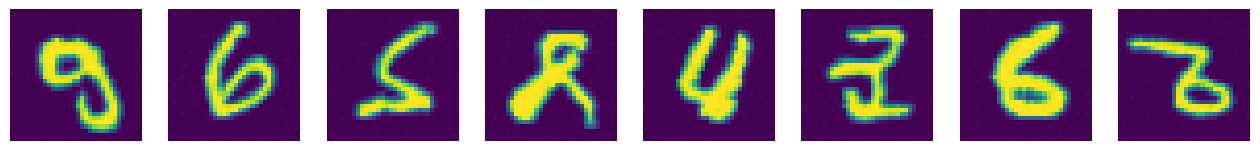

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from eval import sample

# Set model to evaluation mode
model.eval()

# Number of samples to generate
SAMPLES_PER_CLASS = 10

# Sampling parameters
with torch.no_grad():
    samples = sample(model, NUM_CLASSES, SAMPLES_PER_CLASS, INPUT_SIZE, TIMESTEPS, a_t, b_t, ab_t)

    fig, axes = plt.subplots(NUM_CLASSES + 1, SAMPLES_PER_CLASS, figsize=((NUM_CLASSES + 1) * 1.5, SAMPLES_PER_CLASS * 1.5))
    
    for idx, ax in enumerate(axes.flatten()):
        img = np.transpose(samples[idx], (1, 2, 0))
        ax.imshow(img)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
from torch.utils.data import Subset

FORGET_LABEL = 0

training_data = dataset(root='./data', train=True, download=True, transform=transforms.Compose(NORMALIZATIONS), target_transform=TARGET_TRANSFORM)

# Class forgetting
original_trainset = training_data
unlearning_data = Subset(original_trainset, [i for i, (_, label) in enumerate(original_trainset) if label.argmax() == FORGET_LABEL])
training_data = Subset(original_trainset, [i for i, (_, label) in enumerate(original_trainset) if label.argmax() != FORGET_LABEL])

# Load data loaders
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
unlearn_dataloader = DataLoader(unlearning_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

In [14]:
for _, b in unlearn_dataloader:
    print(b)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
import eval

from tqdm import tqdm

SAVE_FILE = 'weights/modelNG10000.pth'
EPOCHS = 200
EVAL_EVERY = 5
UNLEAN_GRAD_METHOD = 'both' # 'both' or 'ascent

model.to('cuda')
model.train()

test_loss = None
test_accuracy = None

# NegGrad unlearning
with tqdm(range(EPOCHS), unit='epoch', desc='retain_accuracy=None, forget_accuracy=None, test_accuracy=None, retain_loss=None, forget_loss=None, test_loss=None') as pbar:
    for epoch in pbar:
        retain_running_loss, forget_running_loss = 0.0, 0.0
        retain_correct_predictions, forget_correct_predictions = 0, 0
        retain_total_predictions, forget_total_predictions = 0, 0

        for (retain_inputs, retain_labels), (forget_inputs, forget_labels) in zip(train_dataloader, unlearn_dataloader):
            # Move inputs and labels to the specified device
            retain_inputs, retain_labels = retain_inputs.to('cuda'), retain_labels.to('cuda')
            forget_inputs, forget_labels = forget_inputs.to('cuda'), forget_labels.to('cuda')

            # Compute predictions
            retain_outputs = model(retain_inputs)
            forget_outputs = model(forget_inputs)
            _, retain_predictions = torch.max(retain_outputs.data, 1)
            _, forget_predictions = torch.max(forget_outputs.data, 1)

            # Update the running total of correct predictions and samples
            retain_correct_predictions += (retain_predictions == retain_labels).sum().item()
            forget_correct_predictions += (forget_predictions == forget_labels).sum().item()
            retain_total_predictions += retain_labels.size(0)
            forget_total_predictions += forget_labels.size(0)

            # Compute the loss and its gradients
            retain_loss = criterion(retain_outputs, retain_labels)
            forget_loss = criterion(forget_outputs, forget_labels)
            retain_running_loss += retain_loss.item()
            forget_running_loss += forget_loss.item()
            (-1.0 * forget_loss).backward()

            if UNLEAN_GRAD_METHOD == 'both':
                retain_loss.backward()

            # Adjust learning weights and zero gradients
            optimizer.step()
            optimizer.zero_grad()

        # Calculate the average loss and accuracy
        retain_loss = retain_running_loss / len(train_dataloader)
        forget_loss = forget_running_loss / len(train_dataloader)
        retain_accuracy = 100 * retain_correct_predictions / retain_total_predictions
        forget_accuracy = 100 * forget_correct_predictions / forget_total_predictions
        
        test_loss, test_accuracy = eval.test(model, test_dataloader, criterion)

        pbar.set_postfix(test_loss=test_loss, forget_loss=forget_loss, retain_loss=retain_loss, test_accuracy=test_accuracy, forget_accuracy=forget_accuracy, retain_accuracy=retain_accuracy)

        if test_loss > forget_loss:
            break

run_logger.info(f'NegGrad unlearning complete: save_file={SAVE_FILE}, train_loss={train_loss}, train_accuracy={train_accuracy}, test_loss={test_loss}, test_accuracy={test_accuracy}')
torch.save(model, SAVE_FILE)

In [ ]:
import eval

from orthograd import OrthogonalGrad, AdamUpdateDirection
from tqdm import tqdm

SAVE_FILE = 'weights/modelOG10000.pth'
EPOCHS = 200
EVAL_EVERY = 5

model.to('cuda')
model.train()

test_loss = None
test_accuracy = None

optimizer_retain = AdamUpdateDirection(model.parameters())
optimizer_forget = AdamUpdateDirection(model.parameters())

unlearn_method = OrthogonalGrad(
    lr=LEARNING_RATE,
    loss=criterion,
    optimizer_retain=optimizer_retain,
    optimizer_unlearn=optimizer_forget,
    retain_grad_mode='per_sample',
    update_mode='both',
    original_model=model,
    grad_mask=None,
    alpha=0.5,
)

# NegGrad unlearning
with tqdm(range(EPOCHS), unit='epoch', desc='retain_accuracy=None, forget_accuracy=None, test_accuracy=None, retain_loss=None, forget_loss=None, test_loss=None') as pbar:
    for epoch in pbar:
        retain_running_loss, forget_running_loss = 0.0, 0.0
        retain_correct_predictions, forget_correct_predictions = 0, 0
        retain_total_predictions, forget_total_predictions = 0, 0
        model.train() # Set the model to training mode

        for (retain_inputs, retain_labels), (forget_inputs, forget_labels) in zip(train_dataloader, unlearn_dataloader):
            # Move inputs and labels to the specified device
            retain_inputs, retain_labels = retain_inputs.to('cuda'), retain_labels.to('cuda')
            forget_inputs, forget_labels = forget_inputs.to('cuda'), forget_labels.to('cuda')

            # Compute predictions
            retain_outputs = model(retain_inputs)
            forget_outputs = model(forget_inputs)
            _, retain_predictions = torch.max(retain_outputs.data, 1)
            _, forget_predictions = torch.max(forget_outputs.data, 1)

            # Update the running total of correct predictions and samples
            retain_correct_predictions += (retain_predictions == retain_labels).sum().item()
            forget_correct_predictions += (forget_predictions == forget_labels).sum().item()
            retain_total_predictions += retain_labels.size(0)
            forget_total_predictions += forget_labels.size(0)

            # Compute the loss and its gradients
            forget_loss, retain_loss = unlearn_method(
                model, forget_inputs, forget_labels, retain_inputs, retain_labels
            )

            retain_running_loss += retain_loss.item()
            forget_running_loss += forget_loss.item()

        # Calculate the average loss and accuracy
        retain_avg_loss = retain_running_loss / len(train_dataloader)
        forget_avg_loss = forget_running_loss / len(train_dataloader)
        retain_accuracy = 100 * retain_correct_predictions / retain_total_predictions
        forget_accuracy = 100 * forget_correct_predictions / forget_total_predictions
        
        test_loss, test_accuracy = eval.test(model, test_dataloader, criterion)

        pbar.set_postfix(test_loss=test_loss, forget_loss=forget_loss, retain_loss=retain_loss, test_accuracy=test_accuracy, forget_accuracy=forget_accuracy, retain_accuracy=retain_accuracy)
        
        if test_loss > forget_loss:
            break

run_logger.info(f'OrthoGrad unlearning complete: save_file={SAVE_FILE}, train_loss={train_loss}, train_accuracy={train_accuracy}, test_loss={test_loss}, test_accuracy={test_accuracy}')
torch.save(model, SAVE_FILE)

In [ ]:
import eval
import math

from tqdm import tqdm
from gdr_gma import MemoryBank, get_gradient, rectify_graident

SAVE_FILE = 'weights/modelGG10000.pth'
EPOCHS = 200
EVAL_EVERY = 5

model.to('cuda')
model.train()

test_loss = None
test_accuracy = None

batches = math.ceil(len(zip(train_dataloader, unlearn_dataloader)) / BATCH_SIZE)
bank = MemoryBank(size=batches)

# NegGrad unlearning
with tqdm(range(EPOCHS), unit='epoch', desc='retain_accuracy=None, forget_accuracy=None, test_accuracy=None, retain_loss=None, forget_loss=None, test_loss=None') as pbar:
    for epoch in pbar:
        retain_running_loss, forget_running_loss = 0.0, 0.0
        retain_correct_predictions, forget_correct_predictions = 0, 0
        retain_total_predictions, forget_total_predictions = 0, 0

        for (retain_inputs, retain_labels), (forget_inputs, forget_labels) in zip(train_dataloader, unlearn_dataloader):
            # Move inputs and labels to the specified device
            retain_inputs, retain_labels = retain_inputs.to('cuda'), retain_labels.to('cuda')
            forget_inputs, forget_labels = forget_inputs.to('cuda'), forget_labels.to('cuda')

            # Compute predictions
            retain_outputs = model(retain_inputs)
            forget_outputs = model(forget_inputs)
            _, retain_predictions = torch.max(retain_outputs.data, 1)
            _, forget_predictions = torch.max(forget_outputs.data, 1)

            # Update the running total of correct predictions and samples
            retain_correct_predictions += (retain_predictions == retain_labels).sum().item()
            forget_correct_predictions += (forget_predictions == forget_labels).sum().item()
            retain_total_predictions += retain_labels.size(0)
            forget_total_predictions += forget_labels.size(0)

            # Compute the loss and its gradients
            retain_loss = criterion(retain_outputs, retain_labels)
            forget_loss = criterion(forget_outputs, forget_labels)
            retain_running_loss += retain_loss.item()
            forget_running_loss += forget_loss.item()

            retain_loss.backward()
            retain_grads = get_gradient(model)
            optimizer.zero_grad()

            (-1.0 * forget_loss).backward()
            forget_grads = get_gradient(model)
            optimizer.zero_grad()

            rectified_retain_grads, rectified_forget_grads = rectify_graident(retain_grads, forget_grads)
            if epoch > 0 and bank.mean_grads(rectified_forget_grads[-1]) != None:
                grads, _ = rectify_graident([rectified_forget_grads[-1]], [bank.mean_grads(rectified_forget_grads[-1])])
                rectified_forget_grads[-1] = grads[-1]
                
            with torch.no_grad():
                    gamma, epsilon = 100, 0.02
                    lambda_weight = 1/(1+torch.exp(gamma*(retain_loss-epsilon)))

            idx = 0
            
            for _, param in model.named_parameters():
                if param.requires_grad:
                    param.grad =  ((1-lambda_weight)*rectified_retain_grads[idx]+lambda_weight*rectified_forget_grads[idx]).view(param.size())
                    idx += 1

            optimizer.step()
            optimizer.zero_grad()

        # Calculate the average loss and accuracy
        retain_loss = retain_running_loss / len(train_dataloader)
        forget_loss = forget_running_loss / len(train_dataloader)
        retain_accuracy = 100 * retain_correct_predictions / retain_total_predictions
        forget_accuracy = 100 * forget_correct_predictions / forget_total_predictions
        
        test_loss, test_accuracy = eval.test(model, test_dataloader, criterion)

        pbar.set_postfix(test_loss=test_loss, forget_loss=forget_loss, retain_loss=retain_loss, test_accuracy=test_accuracy, forget_accuracy=forget_accuracy, retain_accuracy=retain_accuracy)

        if test_loss > forget_loss:
            break

run_logger.info(f'GDR-GMA unlearning complete: save_file={SAVE_FILE}, train_loss={train_loss}, train_accuracy={train_accuracy}, test_loss={test_loss}, test_accuracy={test_accuracy}')
torch.save(model, SAVE_FILE)

In [ ]:
from pyhessian import hessian

HESSIAN_MAX_ITER = 10
HESSIAN_TOP_N = 3

for blk in model.blocks:
    blk.attn.fused_attn = False

hessian_comp = hessian(model,
                        criterion,
                        dataloader=train_dataloader,
                        cuda=torch.device('cuda'))

top_eigenvalues, _ = hessian_comp.eigenvalues(maxIter=HESSIAN_MAX_ITER, top_n=HESSIAN_TOP_N) # Compute eigenvalues
# trace = hessian_comp.trace() # Compute trace
# density_eigen, density_weight = hessian_comp.density() # Compute density

print("Hessian top eigenvalues: ", top_eigenvalues)